In [1]:
import torch
import torch.nn as nn
import numpy as np
import time
import os
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from scipy.stats import binned_statistic

from models import CFM
from models import Flow, FlowSubtraction
from models import Classifier
from omnifold_dataset import OmniFoldDataset
from plots import plot_naive_unfold, plot_reweighted_distribution, plot_prior_unfold, SetStyle
SetStyle()


# OmniFold Example, let's load the following datasets:
1. Reco-level simulation
2. Gen-level simulation
3. Background simulation
4. Reco-level data
5. Gen-level data
6. Background data

In [2]:
data_params = { "path": "./",
                "n_dim": 6,
                "n_mc": 100000,               
                "n_data": 100000,                
                "n_background": 10000,                
                "empty_value": -5.0,
}

In [3]:
OmniModel = OmniFoldDataset(data_params)

# Define background subtraction flow

In [4]:
bkg_mc = OmniModel.mc_background_rec

In [5]:
flow_params = {"hidden_layers": 6,
               "internal_size": 128,
               "lr": 1.e-5,
               "n_epochs" : 1000,
               "batch_size" : 256,
               "batch_size_sample": 2000}

In [6]:
background_generator = Flow(dims_x = data_params['n_dim'], dims_c = 0,params = flow_params)

In [7]:
background_generator.train(bkg_mc,weights = torch.ones_like(bkg_mc[:,0]))

Training generative model for 1000 epochs with lr 1e-05
    Finished epoch 0 with average loss 2.656750656919465e+22 after time 1.7
    Finished epoch 200 with average loss 6.6885881423950195 after time 318.2
    Finished epoch 400 with average loss 5.579853534698486 after time 630.4
    Finished epoch 600 with average loss 5.463485240936279 after time 929.1
    Finished epoch 800 with average loss 5.412261009216309 after time 1227.7
    Finished epoch 999 with average loss 5.412907123565674 after time 1525.5


In [8]:
generated_background = background_generator.evaluate(num_evts = OmniModel.mc_background_rec.size(0))

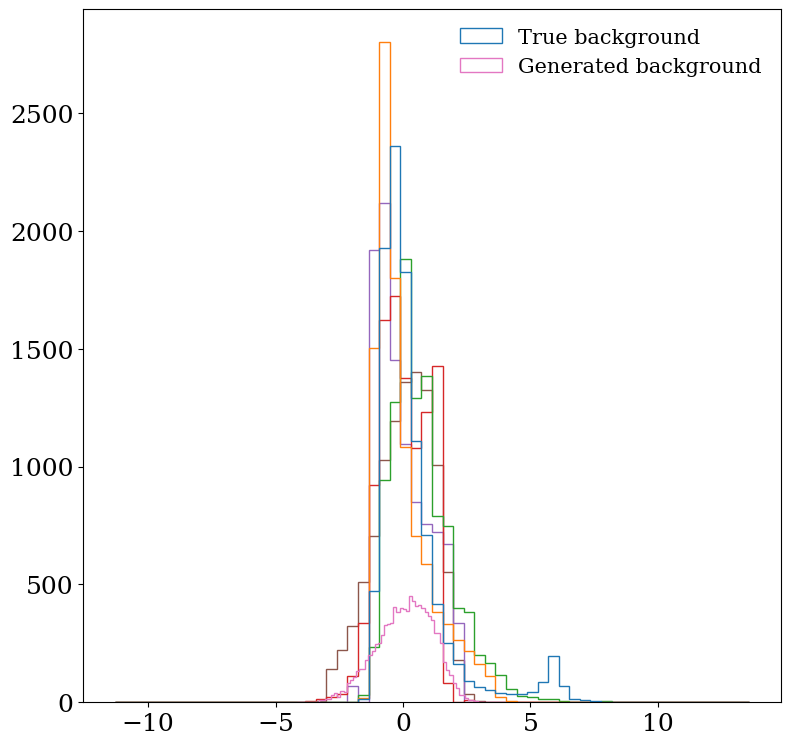

In [9]:
y_true = plt.hist(OmniModel.mc_background_rec[:,].cpu().detach().numpy(),bins = 60,label = "True background", histtype='step')
y_gen = plt.hist(generated_background[:,5].cpu().detach().numpy(),bins = 60,label = "Generated background", histtype='step')
plt.legend()

In [10]:
if not os.path.exists("Plots"):
    os.makedirs("Plots")

with PdfPages(f"Plots/background_generated.pdf") as out:
    plot_reweighted_distribution(out, 
                                 ToyModel.mc_background_rec[:,0].cpu().detach().numpy(),
                                 generated_background[:,0].cpu().detach().numpy(),
                                 np.random.normal(0, 1.0, size=ToyModel.mc_background_rec[:,0].size(0)),
                                 range=[-3,4], labels=[r"true background" , "gaussian", "background generated",], name="x_1")    

/tmp/ipykernel_285528/2193017660.py:4: MatplotlibDeprecationWarning: Keeping empty pdf files is deprecated since 3.8 and support will be removed two minor releases later.
  with PdfPages(f"Plots/background_generated.pdf") as out:


NameError: name 'ToyModel' is not defined

In [ ]:
signal_generator = FlowSubtraction(dims_x = data_params['n_dim'], dims_c = 0,params = flow_params,
                                   background_model = background_generator.network,
                                   bkg_fraction = data_params["n_background"]*1.0/(data_params["n_data"] +  data_params["n_background"]))

In [ ]:
signal_generator.train(ToyModel.data_rec[ToyModel.data_rec_mask.bool()],weights = torch.ones_like(ToyModel.data_rec[ToyModel.data_rec_mask.bool()][:,0]))

# Generate the signal and generate empty events at reco level

In [ ]:
num_data_reco = ToyModel.data_signal_rec[:,0][ToyModel.data_rec_mask[:data_params["n_data"]].bool()].size(0)
generated_signal = signal_generator.evaluate(num_evts = num_data_reco) #N*(1-delta)

In [ ]:
y_true = plt.hist(ToyModel.data_signal_rec[:,0][ToyModel.data_rec_mask[:data_params["n_data"]].bool()].cpu().detach().numpy(),bins = 60, range = [-5.5,4],label = "True signal", histtype='step')
y_gen = plt.hist(generated_signal[:,0].cpu().detach().numpy(),bins = 60, range = [-5.5,4],label = "Generated signal", histtype='step')
plt.legend()

In [ ]:
num_data_empty = num_data_reco*data_params['acceptance']/(1.0 - data_params['acceptance']) #N*(1-delta)*epsilon/(1-epsilon)
#Add the empty events to the generated signals
generated_signal = torch.cat([generated_signal,data_params["empty_value"]*torch.ones_like(generated_signal[:int(num_data_empty)])])

In [ ]:
print(f"Number of expected signal events in the data {generated_signal.size(0)}")

# Train Acceptance classifier

In [ ]:
acceptance_true = ToyModel.mc_rec[(ToyModel.mc_rec_mask.bool()) & (ToyModel.mc_gen_mask.bool())]
acceptance_false = ToyModel.mc_rec[(ToyModel.mc_rec_mask.bool()) & ~(ToyModel.mc_gen_mask.bool())]

In [ ]:
acceptance_classifier_params = { "hidden_layers": 4,
                                 "internal_size": 64,
                                 "lr": 1.e-4,
                                 "n_epochs" : 30,
                                 "batch_size" : 128,
                                 "batch_size_sample": 2000
}

In [ ]:
acceptance_classifier = Classifier(dims_in=1, params=acceptance_classifier_params)

In [ ]:
acceptance_classifier.train_classifier(acceptance_true, acceptance_false, balanced=False)

# Train efficiency classifier

In [ ]:
efficiency_classifier_params = { "hidden_layers": 4,
                                 "internal_size": 64,
                                 "lr": 1.e-4,
                                 "n_epochs" : 30,
                                 "batch_size" : 128,
                                 "batch_size_sample": 2000
}

In [ ]:
efficiency_true = ToyModel.mc_gen[(ToyModel.mc_rec_mask.bool()) & (ToyModel.mc_gen_mask.bool())]
efficiency_false = ToyModel.mc_gen[~(ToyModel.mc_rec_mask.bool()) & (ToyModel.mc_gen_mask.bool())]

In [ ]:
efficiency_classifier = Classifier(dims_in = 1, params = efficiency_classifier_params)

In [ ]:
efficiency_classifier.train_classifier(efficiency_true, efficiency_false, balanced=False)

# Let's train the detector response flow p(reco|gen) and the initial p(gen) flows

In [ ]:
gen_generator = Flow(dims_x = data_params['n_dim'], dims_c = 0,params = flow_params)

In [ ]:
gen_generator.train(ToyModel.mc_gen[ToyModel.mc_gen_mask.bool()],weights = torch.ones_like(ToyModel.mc_gen[ToyModel.mc_gen_mask.bool()][:,0]))

In [ ]:
y_true = plt.hist(ToyModel.mc_gen[:,0][ToyModel.mc_gen_mask.bool()].cpu().detach().numpy(),
                  bins = 60, range = [-5.5,4],label = "MC gen signal", histtype='step')
y_gen = plt.hist(gen_generator.evaluate(num_evts = ToyModel.mc_gen[ToyModel.mc_gen_mask.bool()].size(0)).cpu().detach().numpy(),
                 bins = 60, range = [-5.5,4],label = "Generated gen signal", histtype='step')
plt.legend()

In [ ]:
detector_generator = Flow(dims_x = data_params['n_dim'], dims_c = data_params['n_dim'],params = flow_params)

In [ ]:
detector_generator.train(ToyModel.mc_rec[ToyModel.mc_rec_mask.bool()],
                         weights = torch.ones_like(ToyModel.mc_rec[ToyModel.mc_rec_mask.bool()][:,0]), 
                         data_c = ToyModel.mc_gen[ToyModel.mc_rec_mask.bool()])

In [ ]:
y_true = plt.hist(ToyModel.mc_rec[:,0][ToyModel.mc_rec_mask.bool()].cpu().detach().numpy(),
                  bins = 60, range = [-5.5,4],label = "MC reco signal", histtype='step')
y_gen = plt.hist(detector_generator.evaluate(data_c = ToyModel.mc_gen[ToyModel.mc_rec_mask.bool()]).cpu().detach().numpy(),
                 bins = 60, range = [-5.5,4],label = "Generated MC reco signal", histtype='step')
plt.legend()

# Start the unfolding!

In [ ]:
def sample_reco(nevts,empty_fraction, efficiency_classifier,detector_model,gen_model):
    ''' Generates h(reco|gen) samples by sampling from: h(reco|gen) = c(gen) + (1-c(gen))*p(reco|gen)*p(gen) '''
    gen_events = gen_model.evaluate(num_evts = nevts)
    gen_mask = ToyModel.apply_efficiency_acceptance_effects(gen_events,empty_fraction)
    gen_events[~gen_mask.bool()] = data_params["empty_value"]*torch.ones_like(gen_events[~gen_mask.bool()])
    
    efficiency = efficiency_classifier.evaluate(gen_events, return_weights=False)
    sample_efficiency = torch.bernoulli(efficiency)
    
    reco_events = detector_model.evaluate(data_c=gen_events)
    reco_events[~sample_efficiency.bool()] = data_params["empty_value"]*torch.ones_like(gen_events[~sample_efficiency.bool()])
    return  reco_events, gen_events, gen_mask 

In [ ]:
iterations = 5
unfold_generator =  Flow(dims_x = data_params['n_dim'], dims_c = data_params['n_dim'],params = flow_params)
for i in range(iterations):
    print(f"Running iteration {i}")
    reco_train, gen_train, gen_mask = sample_reco(data_params['n_mc'], 
                                                 data_params['efficiency'],
                                                 efficiency_classifier,
                                                 detector_generator,
                                                 gen_generator)
    unfold_generator.train(gen_train[gen_mask.bool()], 
                           weights = torch.ones_like(gen_train[gen_mask.bool()][:,0]), 
                           data_c = reco_train[gen_mask.bool()])
    unfolded = unfold_generator.evaluate(data_c=generated_signal)
    gen_generator.train(unfolded,weights = torch.ones_like(unfolded[:,0]))
    #FIXME: Probably need to update the efficiency classifier here
    fig, axes = plt.subplots()
    axes.hist(unfolded[:,0].cpu().detach().numpy(), bins=60, histtype="step", range=[-5.5,4],label="Gen. Unfolded",density=True)
    axes.hist(ToyModel.mc_gen[:,0][ToyModel.mc_gen_mask.bool()].cpu().detach().numpy(),bins=60, histtype='step', range=[-5.5,4],label="Gen. MC",density=True)
    axes.hist(ToyModel.data_gen[:,0][ToyModel.data_gen_mask.bool()].cpu().detach().numpy(), 
              bins=60, range=[-5.5,4], histtype="step", label="Gen. Truth pass all",density=True)
    plt.legend()  # Display the legend
    plt.show()

# Fix Acceptance with empty true events

In [ ]:
acceptance = acceptance_classifier.evaluate(generated_signal, return_weights=False)
acceptance_mask = torch.bernoulli(acceptance)
unfolded = unfolded[acceptance_mask.bool()]
print(f"Unfolded true events {unfolded.size(0)}, Number of true data events {torch.sum(ToyModel.data_gen_mask.bool())}")

In [ ]:
with PdfPages(f"Plots/final_generative_unfolding.pdf") as out:
    plot_naive_unfold(out, 
                      ToyModel.data_gen[:, 0][ToyModel.data_gen_mask.bool()].cpu().detach().numpy(),
                      ToyModel.data_rec[:, 0][ToyModel.data_rec_mask.bool()].cpu().detach().numpy(),
                      unfolded[:, 0].cpu().detach().numpy(),
                      range=[-3, 4], name="x_1")